In [1]:
# This is a workbook used to analyse the movement of users that was collected from April 2007 to April 2012
# This was done by dividing the total area into zones and then calculating the number of users in each zone every hour
# It is also important to state the number of users in each zone per hour was calculated differently for the weekdays and weekends
# Import all the required packages 
import skmob
import geopandas as gpd
from skmob.preprocessing import detection, clustering, compression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skmob.tessellation import tilers

In [2]:
# Read the csv file
# tdf = skmob.TrajDataFrame.from_file('newGeolife.csv')
df = pd.read_csv('newGeolife.csv')

In [3]:
# Remove the unnamed column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# use skmob to read the loaded dataframe
tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lng', datetime = 'datetime')

In [5]:
# stdf = detection.stops(tdf, stop_radius_factor=0.5, minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True)

In [7]:
# Remove points that falls outside the boundary of the study-site which is beijing
tdf=tdf[(tdf['lat']<40.35) & (tdf['lat']>39.7)]
tdf=tdf[(tdf['lng']<116.8) & (tdf['lng']>116)]

In [8]:
tdf.dtypes

lat                float64
lng                float64
datetime    datetime64[ns]
uid                 object
dtype: object

In [9]:
# Split the datetime column into two columns named date and time
tdf['date'] = tdf['datetime'].dt.strftime('%Y-%m-%d')
tdf['time'] = tdf['datetime'].dt.strftime('%H:%M:%S')

In [10]:
tdf.head()

,lat,lng,datetime,uid,date,time
0,39.984683,116.318450,2008-10-23 02:53:10,0,2008-10-23,02:53:10
1,39.984686,116.318417,2008-10-23 02:53:15,0,2008-10-23,02:53:15
2,39.984688,116.318385,2008-10-23 02:53:20,0,2008-10-23,02:53:20
3,39.984655,116.318263,2008-10-23 02:53:25,0,2008-10-23,02:53:25
4,39.984611,116.318026,2008-10-23 02:53:30,0,2008-10-23,02:53:30


In [11]:
# Tessellating the study-site
# Tessellation refers to the division of the points on the studies into different zones
tessellation = tilers.tiler.get("squared", base_shape="Beijing, China", meters=15000)
mtdf = tdf.mapping(tessellation)
# tile_ID column is created specifying the zone each points fall into 
mtdf.head()

/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/core/trajectorydataframe.py:322: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tile_ids = gpd.sjoin(gdf, tessellation, how=how, op='within')[[constants.TILE_ID]]


,lat,lng,datetime,uid,date,time,tile_ID
0,39.984683,116.318450,2008-10-23 02:53:10,0,2008-10-23,02:53:10,63
1,39.984686,116.318417,2008-10-23 02:53:15,0,2008-10-23,02:53:15,63
2,39.984688,116.318385,2008-10-23 02:53:20,0,2008-10-23,02:53:20,63
3,39.984655,116.318263,2008-10-23 02:53:25,0,2008-10-23,02:53:25,63
4,39.984611,116.318026,2008-10-23 02:53:30,0,2008-10-23,02:53:30,63


In [12]:
mpf = tdf.to_flowdataframe(tessellation=tessellation, self_loops=True)
mpf

/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/oluleyepeters/miniconda3/envs/env3/lib/python3.8/site-packages/skmob/core/trajectorydataframe.py:322: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tile_ids = gpd.sjoin(gdf, tessellation, how=how, op='within')[[constants.TILE_ID]]


,origin,destination,flow
0,104,104,2239
1,104,105,8
2,104,76,1
3,104,89,1
4,105,104,3
...,...,...,...
483,95,78,1
484,95,81,4
485,95,92,1
486,95,94,68


In [15]:
mpf.plot_tessellation(popup_features=['tile_ID'])

In [16]:
# Create a new column of year, month and day
# A new column named time_hour was created. This column depended on the already existing datetime column
# A point with a datetime value of 2008-10-23 02:53:10 will have a hour value of 02:00:00
# This makes it easier to group and calculate the number of users in each zone per hour

mtdf['year'] = pd.DatetimeIndex(mtdf['datetime']).year
mtdf['month'] = pd.DatetimeIndex(mtdf['datetime']).month
mtdf['day'] = pd.DatetimeIndex(mtdf['datetime']).day
mtdf['hour'] = pd.to_datetime(mtdf['time'], format='%H:%M:%S').dt.hour
mtdf['newTime'] = pd.to_datetime(mtdf[['year','month','day','hour']])
mtdf['time_hour'] = mtdf['newTime'].dt.time

In [18]:
mtdf.head()

,lat,lng,datetime,uid,date,time,tile_ID,year,month,day,hour,newTime,time_hour
0,39.984683,116.318450,2008-10-23 02:53:10,0,2008-10-23,02:53:10,63,2008,10,23,2,2008-10-23 02:00:00,02:00:00
1,39.984686,116.318417,2008-10-23 02:53:15,0,2008-10-23,02:53:15,63,2008,10,23,2,2008-10-23 02:00:00,02:00:00
2,39.984688,116.318385,2008-10-23 02:53:20,0,2008-10-23,02:53:20,63,2008,10,23,2,2008-10-23 02:00:00,02:00:00
3,39.984655,116.318263,2008-10-23 02:53:25,0,2008-10-23,02:53:25,63,2008,10,23,2,2008-10-23 02:00:00,02:00:00
4,39.984611,116.318026,2008-10-23 02:53:30,0,2008-10-23,02:53:30,63,2008,10,23,2,2008-10-23 02:00:00,02:00:00


In [19]:
# The analysis is to check the number of users in each zone per hour.
# Every user that appears more than once in each zone is dropped.
# Results in a user appearing in each zone not more than once
mtdf = mtdf.drop_duplicates(
  subset = ['tile_ID', 'uid', 'newTime'],
  keep = 'last').reset_index(drop = True)

In [21]:
# The analysis compares the maximum number of users obtainable during the weekdays and weekends
# Thus the day_of_the week value was created for each point
mtdf['day_of_week'] = mtdf['datetime'].dt.dayofweek

In [22]:
mtdf.head()
# export the processed dataset as a new dateset
mtdf.to_csv('processed.csv')
# The exported file was opened in excel, and the numbers of a new column named day_name was created
# This column categorised the day_of_week for each point as either a weekday or weekend

In [36]:
# Read processed csv file
df = pd.read_csv('processed.csv')
# Exporting a dataframe and reading it again usually lead to the conversion of the datetime data type to objects
df.dtypes

Unnamed: 0       int64
lat            float64
lng            float64
datetime        object
uid              int64
date            object
time            object
tile_ID          int64
year             int64
month            int64
day              int64
hour             int64
newTime         object
time_hour       object
day_of_week      int64
day_name        object
value            int64
dtype: object

In [37]:
# Convert datetime columns from object type to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
df['newTime'] = pd.to_datetime(df['newTime'])
df['time'] = pd.to_datetime(df['time'])

In [38]:
df.dtypes

Unnamed: 0              int64
lat                   float64
lng                   float64
datetime       datetime64[ns]
uid                     int64
date                   object
time           datetime64[ns]
tile_ID                 int64
year                    int64
month                   int64
day                     int64
hour                    int64
newTime        datetime64[ns]
time_hour              object
day_of_week             int64
day_name               object
value                   int64
dtype: object

In [39]:
# Extract, create and export seperate dateframes for both weekend and weekday points

weekend = df[df['day_name'] == 'Weekend']
weekend.to_csv('weekend.csv')
weekday = df[df['day_name'] == 'Weekday']
weekday.to_csv('weekday.csv')

In [70]:
weekend = pd.read_csv('weekend.csv')
weekday = pd.read_csv('weekday.csv')
# convert datetime data that was converted to object during csv file creation back to datetime data type
weekday['datetime'] = pd.to_datetime(weekday['datetime'])
weekday['newTime'] = pd.to_datetime(weekday['newTime'])
weekday['time'] = pd.to_datetime(weekday['time'])
weekend['datetime'] = pd.to_datetime(weekend['datetime'])
weekend['newTime'] = pd.to_datetime(weekend['newTime'])
weekend['time'] = pd.to_datetime(weekend['time'])

In [71]:
# Drop unecessary columns
weekday.drop('Unnamed: 0', axis=1, inplace=True)
weekday.drop('Unnamed: 0.1', axis=1, inplace=True)

# Weekend
weekend.drop('Unnamed: 0', axis=1, inplace=True)
weekend.drop('Unnamed: 0.1', axis=1, inplace=True)

In [72]:
# Create a list for of the tile_ID(zone created from tessellation) for both weekend and weekday file
weekendtile_List = [tile for tile in weekend['tile_ID']]
weekendtile_List = set(weekendtile_List)
weekendtile_List = list(weekendtile_List)

weekdaytile_List = [tile for tile in weekday['tile_ID']]
weekdaytile_List = set(weekdaytile_List)
weekdaytile_List = list(weekdaytile_List)

In [73]:
import copy
# create column headings for a dataframe to be created
column_names = ['time_hour']
# extend the column headings with the list of tile_ID created initially
column_names.extend(weekdaytile_List)
# Create a dataframe with this column headings
weekdaydf = pd.DataFrame(columns = column_names)
# get all the unique values of time_hour present in the weekday dataframe and add as a column in the new dataframe
time_hour = pd.DataFrame(weekday.time_hour.unique())
weekdaydf['time_hour'] = copy.deepcopy(time_hour[0])
# Loop thrugh the weekdaytile_List and use it to fill the new dataframe with the maximum number of users that could be gotten in each zone per hour during the week.
for index in weekdaytile_List:
    newDf = weekday[weekday['tile_ID'] == index]
    newDf = newDf.groupby(['time_hour','uid'])['value'].nunique()
    newDf = newDf.reset_index()
    newDf = newDf.groupby(['time_hour'])['value'].sum()
    newFrame = pd.DataFrame(newDf)
    newFrame = newFrame.reset_index()
    for i, row in newFrame.iterrows():
        weekdaydf.loc[row.time_hour, index] = row.value

weekdaydf = weekdaydf.iloc[24:]
# replace the Nan filled cells with 0
weekdaydf.drop('time_hour',  axis=1, inplace=True)
# weekdaydf =  weekdaydf.rename(columns= {'index': 'Time'}).fillna(0).sort_index().transpose()

weekdaydf =  weekdaydf.rename(columns= {'index': 'Time'}).fillna(0).sort_index()
weekdaydf

,36,37,38,39,40,41,42,47,48,49,...,108,109,110,119,120,121,122,123,124,125
00:00:00,1,2,1,3,3,0,5,2,3,9,...,5,4,7,0,1,4,2,2,1,5
01:00:00,1,2,1,3,1,0,3,2,9,12,...,2,5,9,1,4,3,2,2,0,3
02:00:00,0,0,2,3,3,0,2,2,6,12,...,7,7,9,1,0,3,3,0,0,2
03:00:00,0,0,3,5,6,1,7,1,4,10,...,2,4,5,1,2,1,2,0,2,2
04:00:00,0,0,3,5,5,0,4,4,11,15,...,3,4,7,0,0,1,0,0,2,4
05:00:00,0,0,3,4,6,1,3,1,9,13,...,7,7,9,0,1,2,2,1,0,4
06:00:00,0,0,3,2,5,1,6,1,3,10,...,1,6,8,0,0,1,1,1,1,6
07:00:00,0,1,4,1,5,2,6,4,7,13,...,4,8,8,0,1,4,3,1,0,4
08:00:00,1,1,2,1,4,3,4,3,8,18,...,4,5,5,0,1,2,4,1,0,4
09:00:00,1,1,0,4,4,1,4,4,5,12,...,2,10,11,0,0,2,1,1,1,7


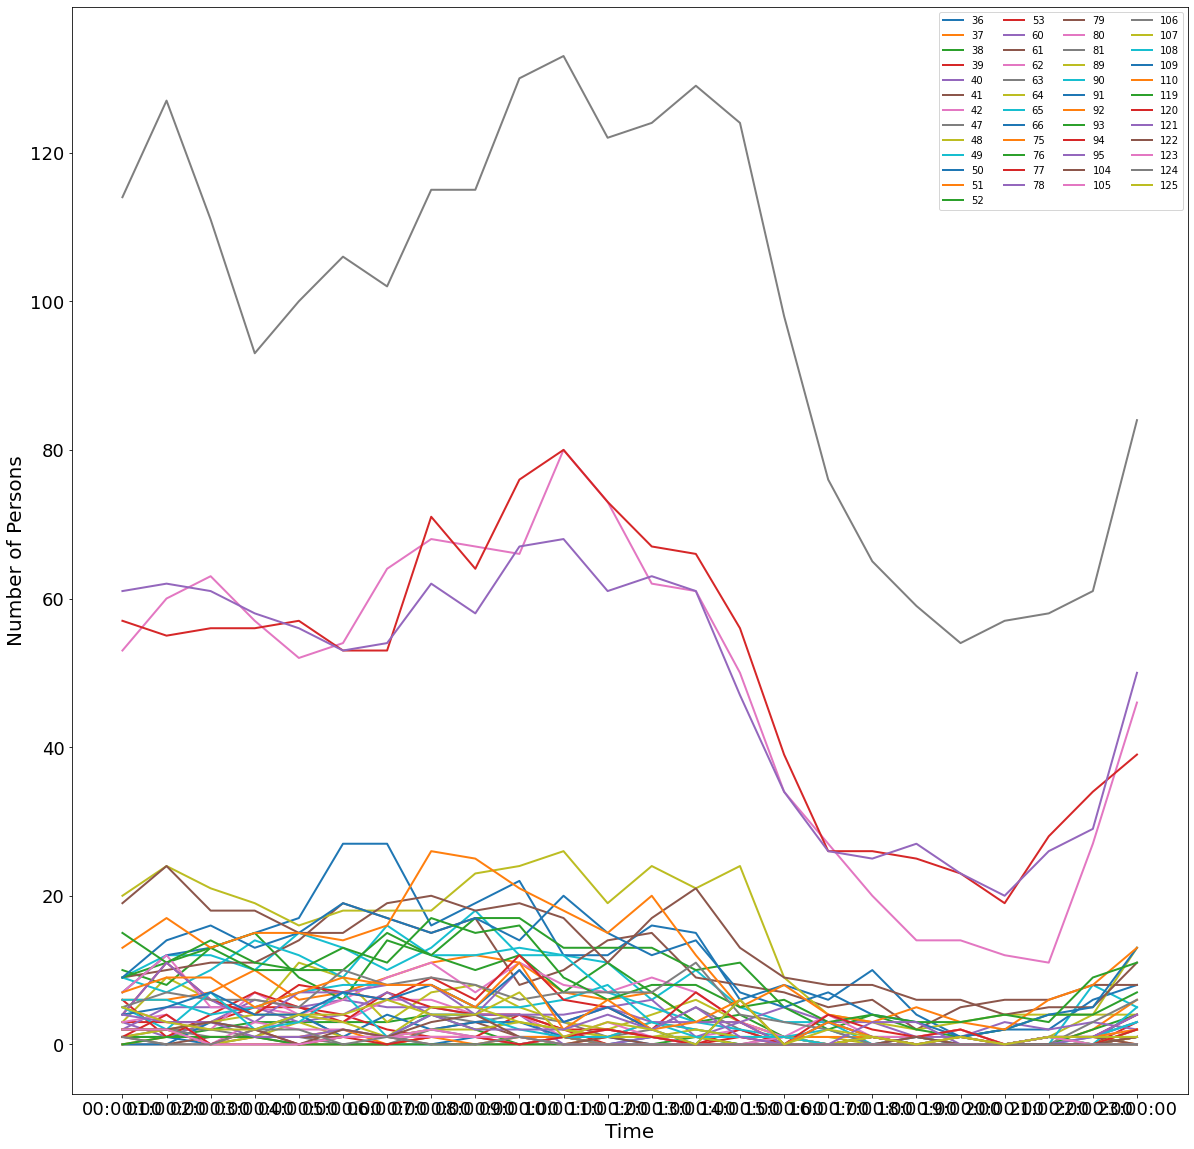

In [74]:
# Plot a line graphs for eaxh of the zone during the weekdays (Monday t0 Friday)

for col in weekdaydf.columns:
    plt.plot(weekdaydf[col], linewidth=2, label=col)
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Persons', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.rcParams["figure.figsize"]=(1,1)
plt.legend(ncol=4)
plt.show()

In [75]:
weekdaydf.reset_index(inplace = True)

In [76]:
# The line graph above has the time muddled together, thus to make it more clearer instead of an interval of 1hr the interval was adjusted to be 2hrs
for (idx, row) in weekdaydf.iterrows():
    if int((str(row.loc['index'])).split(':')[0]) % 2 != 0:
        weekdaydf.drop(idx, inplace = True)

In [77]:
weekdaydf.set_index('index', inplace = True)

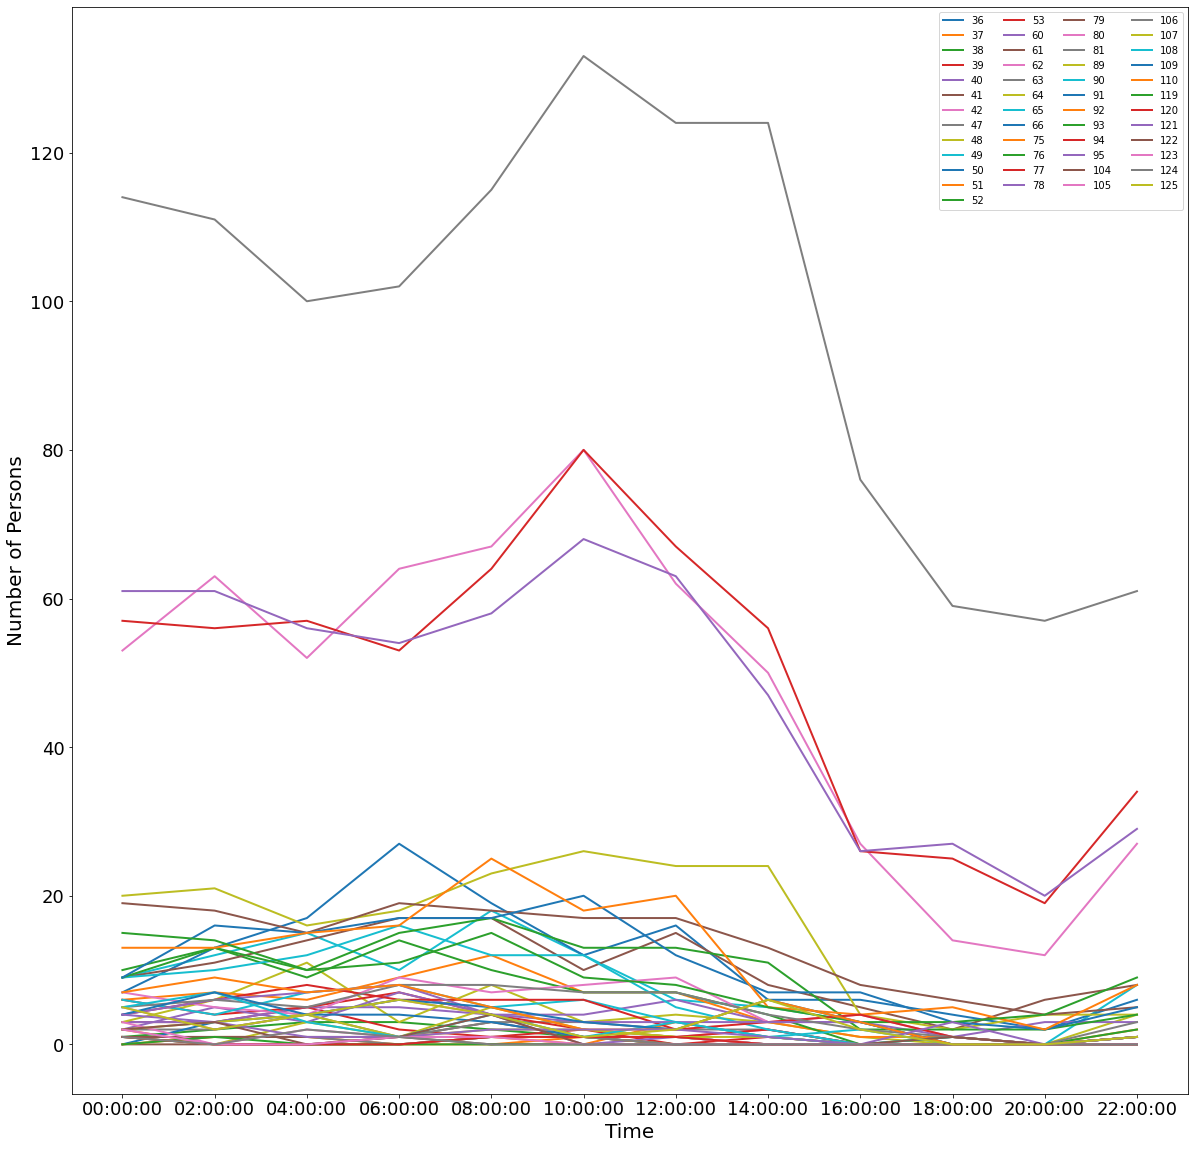

In [79]:
# A new plot of line graphs for each zone was then created with an interval of 2hrs each

for col in weekdaydf.columns:
    plt.plot(weekdaydf[col], linewidth=2, label=col)
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Persons', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.rcParams["figure.figsize"]=(2,2)
plt.legend(ncol=4)
plt.show()

In [80]:
# To make the plot above clearer, the image was zones that coulf not have more than 100 persons over the 24 hour period were removed

for col in weekdaydf.columns:
    if weekdaydf[col].sum() < 100:
        weekdaydf.drop(col, axis = 1 ,inplace = True )
    
weekdaydf

,50,61,62,63,64,76,77,78,79,91,92,93
index,,,,,,,,,,,,
00:00:00,7,9,53,114,20,9,57,61,19,9,13,15
02:00:00,13,11,63,111,21,13,56,61,18,16,13,14
04:00:00,17,14,52,100,16,10,57,56,15,15,15,10
06:00:00,27,17,64,102,18,15,53,54,19,17,16,11
08:00:00,19,17,67,115,23,17,64,58,18,17,25,15
10:00:00,12,10,80,133,26,13,80,68,17,20,18,9
12:00:00,16,15,62,124,24,13,67,63,17,12,20,8
14:00:00,6,8,50,124,24,11,56,47,13,7,5,5
16:00:00,6,5,27,76,4,2,26,26,8,7,4,3


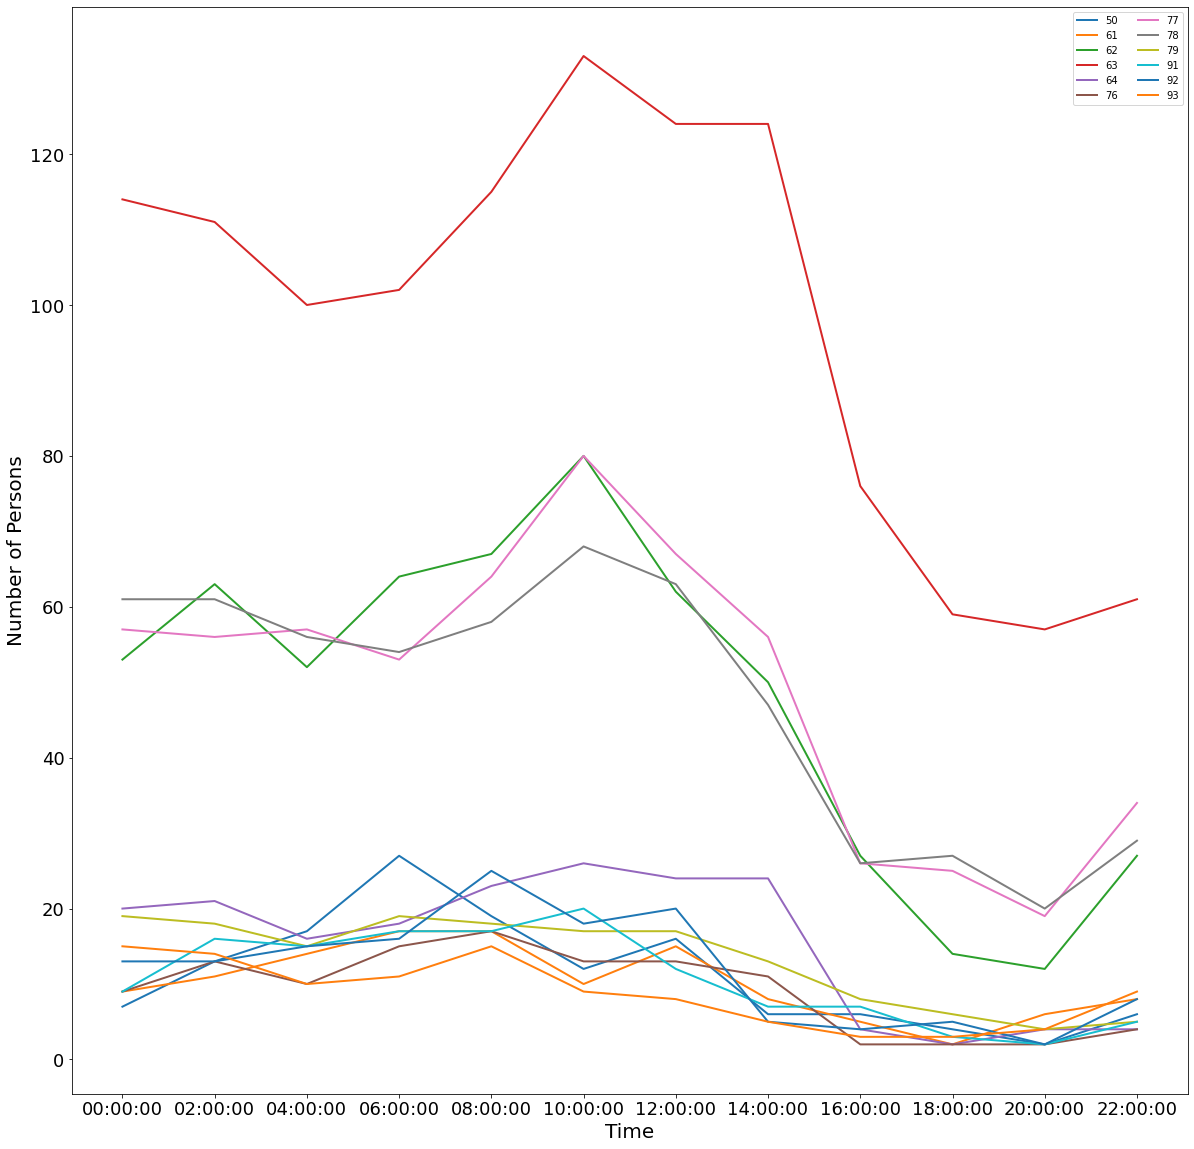

In [84]:
for col in weekdaydf.columns:
    plt.plot(weekdaydf[col], linewidth=2, label=col)
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Persons', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=40)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.rcParams["figure.figsize"]=(1,1)
plt.legend(ncol=2)
plt.show()

Everything done with the Weekday user data was repeated for the weekend user data

In [85]:
import copy
# create column headings for a dataframe to be created
column_names = ['time_hour']
# extend the column headings with the list of tile_ID created initially
column_names.extend(weekendtile_List)
# Create a dataframe with this column headings
weekenddf = pd.DataFrame(columns = column_names)
# get all the unique values of time_hour present in the weekday dataframe and add as a column in the new dataframe
time_hour = pd.DataFrame(weekend.time_hour.unique())
weekenddf['time_hour'] = copy.deepcopy(time_hour[0])
# Loop thrugh the weekdaytile_List and use it to fill the new dataframe with the maximum number of users that could be gotten in each zone per hour during the week.
for index in weekendtile_List:
    newDf = weekend[weekend['tile_ID'] == index]
    newDf = newDf.groupby(['time_hour','uid'])['value'].nunique()
    newDf = newDf.reset_index()
    newDf = newDf.groupby(['time_hour'])['value'].sum()
    newFrame = pd.DataFrame(newDf)
    newFrame = newFrame.reset_index()
    for i, row in newFrame.iterrows():
        weekenddf.loc[row.time_hour, index] = row.value

weekenddf = weekenddf.iloc[24:]
# replace the Nan filled cells with 0
weekenddf.drop('time_hour',  axis=1, inplace=True)
weekenddf =  weekenddf.rename(columns= {'index': 'Time'}).fillna(0).sort_index()
weekenddf

,36,37,38,39,40,41,42,47,48,49,...,107,108,109,110,120,121,122,123,124,125
00:00:00,0,0,0,0,0,0,2,0,3,3,...,1,2,2,3,0,1,0,0,0,1
01:00:00,1,1,1,1,0,1,2,2,3,4,...,1,1,2,3,0,2,1,1,0,1
02:00:00,0,0,1,1,1,1,3,1,1,2,...,1,2,1,1,0,1,1,1,1,1
03:00:00,0,0,0,1,3,1,2,2,3,4,...,0,3,1,2,0,4,0,1,0,1
04:00:00,0,0,0,1,3,1,2,1,3,3,...,0,2,1,0,0,4,1,1,0,0
05:00:00,1,0,0,2,3,1,2,2,6,4,...,0,2,2,2,0,3,0,1,1,1
06:00:00,1,0,0,2,3,1,2,0,1,4,...,1,1,0,2,0,3,1,1,0,1
07:00:00,1,0,1,1,3,1,2,1,1,9,...,0,2,5,5,2,3,0,0,0,2
08:00:00,1,0,1,1,2,1,7,2,6,10,...,0,2,4,4,1,3,0,1,0,2
09:00:00,0,0,1,2,2,0,2,1,4,9,...,1,1,4,4,0,3,0,0,0,4


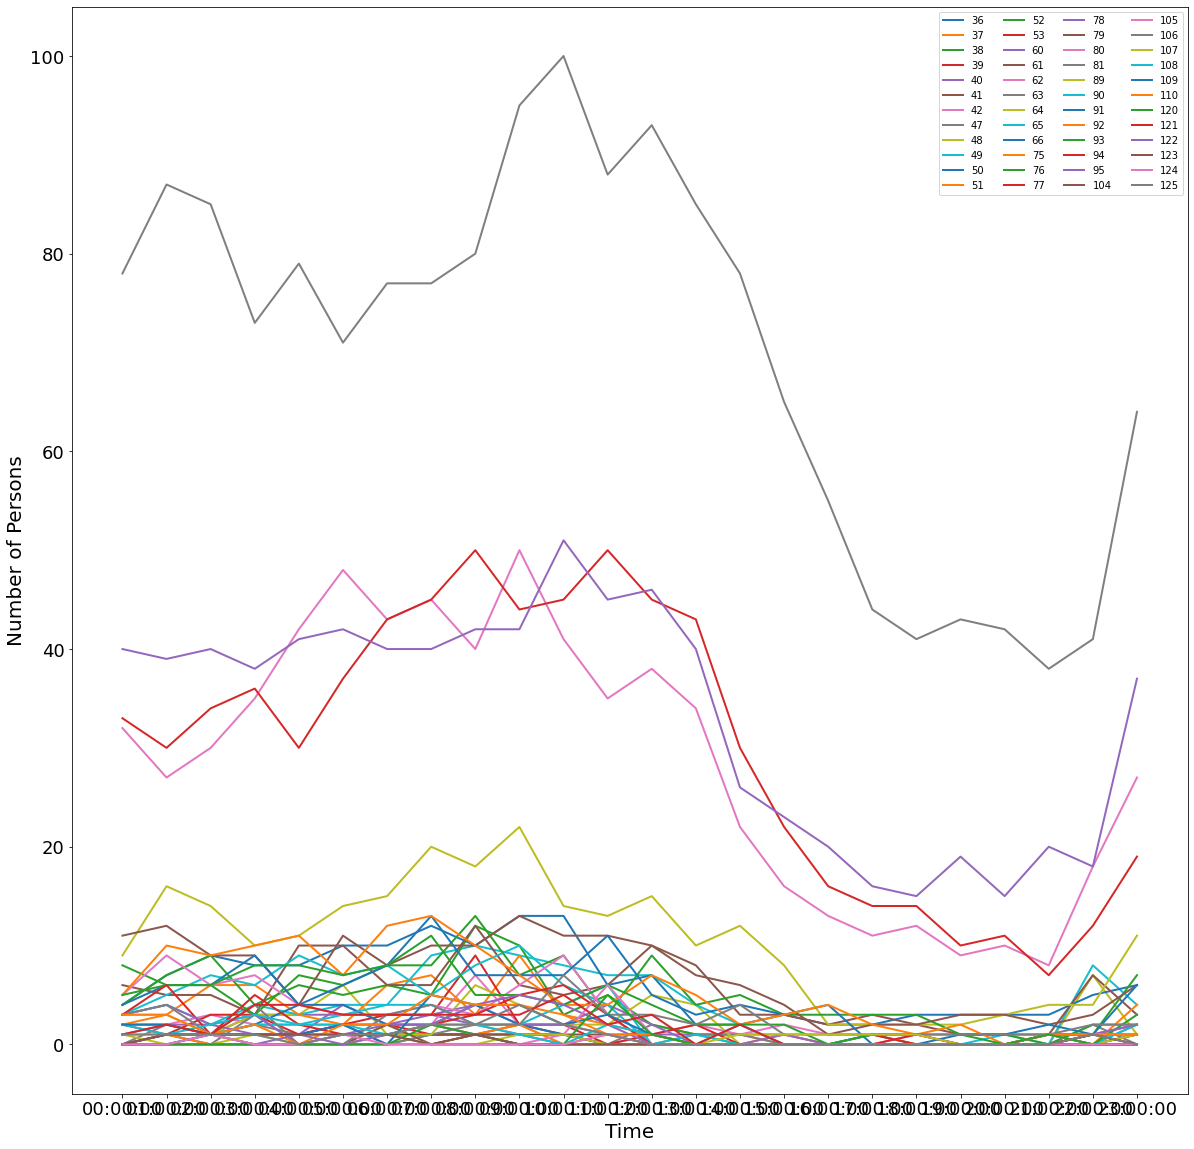

In [88]:
for col in weekenddf.columns:
    plt.plot(weekenddf[col], linewidth=2, label=col)
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Persons', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.rcParams["figure.figsize"]=(1,1)
plt.legend(ncol=4)
plt.show()

In [89]:
weekenddf.reset_index(inplace = True)

In [90]:
for (idx, row) in weekenddf.iterrows():
    if int((str(row.loc['index'])).split(':')[0]) % 2 != 0:
        weekenddf.drop(idx, inplace = True)

In [91]:
weekenddf.set_index('index', inplace = True)

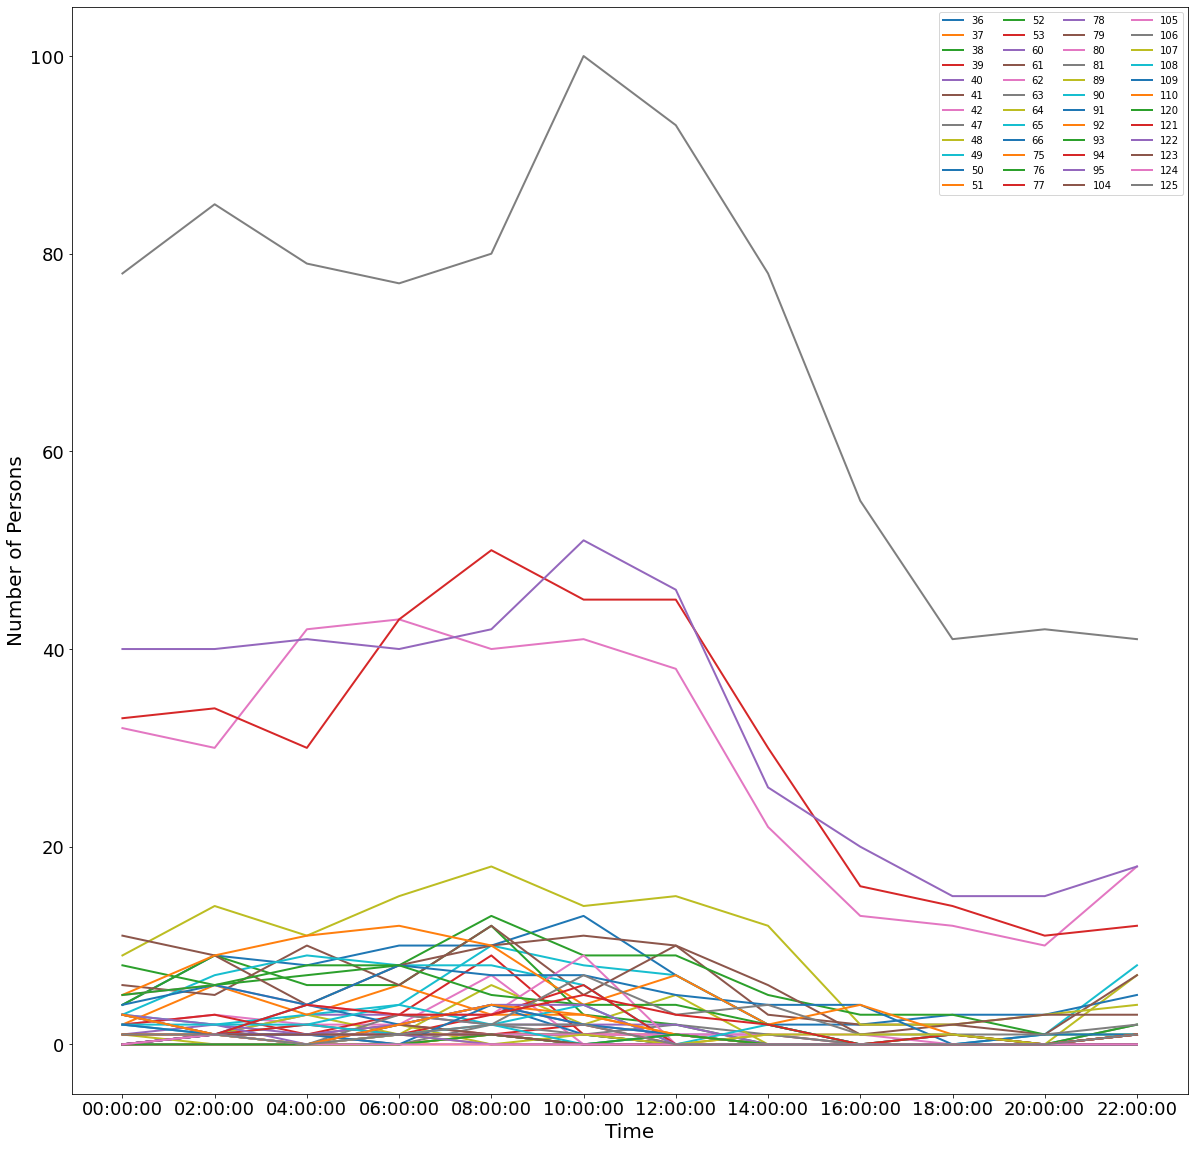

In [94]:
for col in weekenddf.columns:
    plt.plot(weekenddf[col], linewidth=2, label=col)
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Persons', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.rcParams["figure.figsize"]=(2,2)
plt.legend(ncol=4)
plt.show()

In [95]:
for col in weekenddf.columns:
    if weekenddf[col].sum() < 100:
#         print('Hello')
        weekenddf.drop(col, axis = 1 ,inplace = True )
    
weekenddf

,62,63,64,77,78
index,,,,,
00:00:00,32,78,9,33,40
02:00:00,30,85,14,34,40
04:00:00,42,79,11,30,41
06:00:00,43,77,15,43,40
08:00:00,40,80,18,50,42
10:00:00,41,100,14,45,51
12:00:00,38,93,15,45,46
14:00:00,22,78,12,30,26
16:00:00,13,55,2,16,20


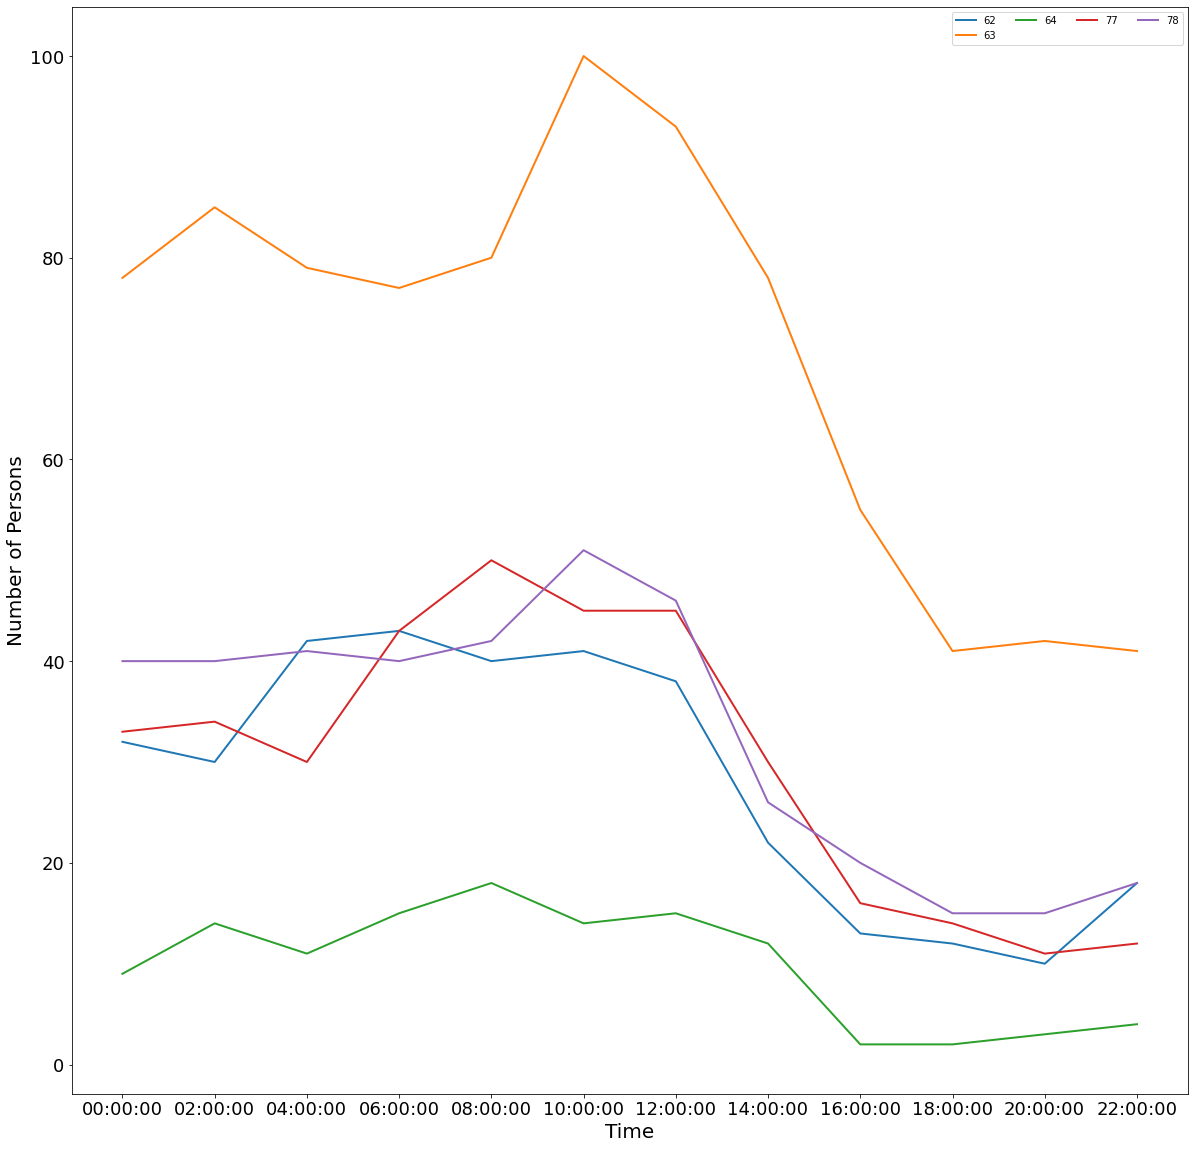

In [97]:
for col in weekenddf.columns:
    plt.plot(weekenddf[col], linewidth=2, label=col)
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Persons', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.rcParams["figure.figsize"]=(2,2)
plt.legend(ncol=4)
plt.show()

From the analysis carried out, Zone 63 was clearly shown to be the zone with most number of persons at any point it time for both the weekend and the weekdays.

Something else that can be deducted from the analysis is that user movement for both the weekdays and weekends are similar. This is because for both plots for the weekend and the weekday, the user movement funtuates rises and fluctuates until around 10am in the morning, before it then goes on a gradual decrease until around 6:00pm in the evening.

Lastly, it cannot be said that an area is a commercial or residential area. This is because the movement pattern for both the weekdays and weekend are similar. Another reason for this can also be seen in the result of the line of code below where it shows that most off the user movement originates and terminates in the same zone. Thus it can be said that most of the users resided and work in the same zone.

In [14]:
mpf.head(50)

,origin,destination,flow
0,104,104,2239
1,104,105,8
2,104,76,1
3,104,89,1
4,105,104,3
5,105,105,8660
6,105,106,5
7,105,120,14
8,105,90,19
9,105,91,2
